In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.svm import LinearSVC

from imblearn.over_sampling import SMOTE

In [2]:
# loading datasets
actives = pd.read_csv('../../mold2_descriptors/2100_actives.csv')
inactives = pd.read_csv('../../mold2_descriptors/2100_inactives.csv')

In [3]:
print('actives:', len(actives))
print('inactives:', len(inactives))

actives: 1165
inactives: 291883


In [4]:
# spliting datasets into test - train & validation
actives_test = actives.sample(n=300, random_state=42)
actives_train = actives.drop(actives_test.index)
inactives_test = inactives.sample(n=300, random_state=42)
inactives_train = inactives.drop(inactives_test.index)

# sampling some inactives
inactives_train = inactives_train.sample(100000)

In [5]:
df = pd.concat([actives_train, inactives_train], ignore_index=True)

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,4.80735,-0.672495,0.300000,0.725439,0
1,1,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,4.95420,-0.338261,0.230769,1.795490,0
2,1,0,0,2,3,0,0,0,0,0,...,0,2,0,0,0,5.52356,-0.661023,0.162162,1.842870,0
3,2,0,0,1,3,0,0,0,0,0,...,0,0,0,0,0,5.39232,-0.693316,0.363636,2.640200,0
4,2,0,1,0,2,0,0,0,0,0,...,0,1,0,0,0,5.12928,-0.699350,0.461538,1.822100,0


In [7]:
X = df.drop(['activity'], axis=1)
y = df['activity']

In [8]:
y.value_counts()

0    100000
1       865
Name: activity, dtype: int64

In [9]:
import matplotlib.pyplot as plt

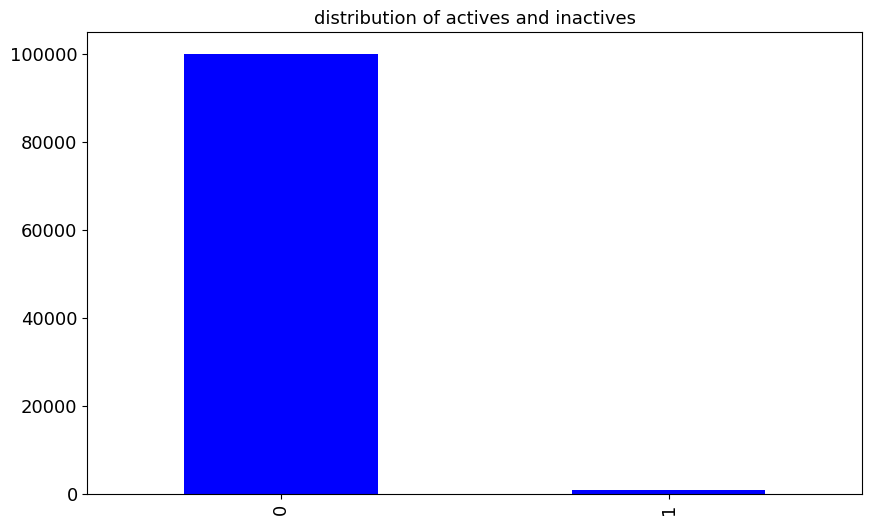

In [10]:
ax = y.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution of actives and inactives', fontsize=13)
ax.set_alpha(0.5)

In [11]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.01, random_state=42)

In [12]:
# normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_validate = pd.DataFrame(X_validate, columns=X.columns)

### Removing low variance features to improve model performance

In [13]:
from sklearn.feature_selection import VarianceThreshold


thresh = VarianceThreshold(threshold=0.03)
thresh.fit(X_train)
mask = thresh.get_support()


X_train = X_train.loc[:, mask]
X_validatee = X_validate.loc[:, mask]

X_train.shape, X_validate.shape

((99856, 646), (1009, 777))

In [14]:
over = SMOTE()
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

In [15]:
y_train_resampled.value_counts()

0    98996
1    98996
Name: activity, dtype: int64

Text(0.5, 1.0, 'distribution in sampled dataset')

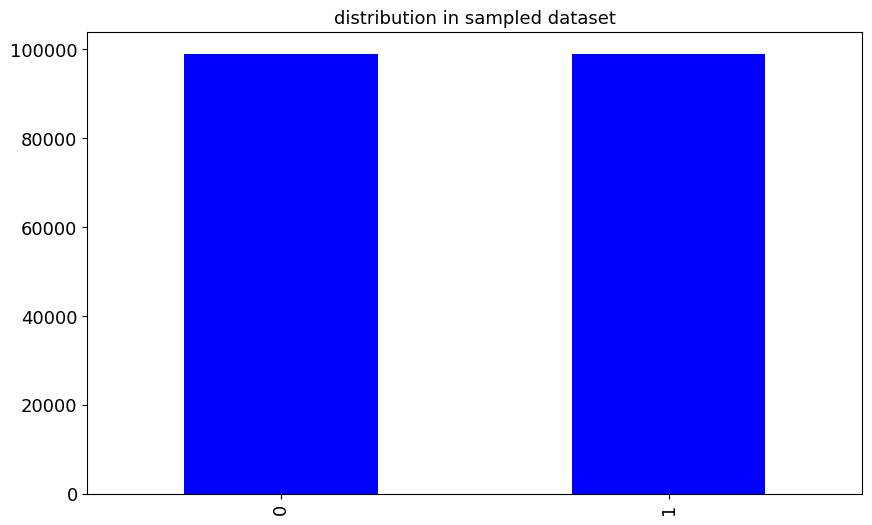

In [16]:
ax = y_train_resampled.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution in sampled dataset', fontsize=13)

## training model with oversampled data

In [17]:
model = LinearSVC(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

### evaluating the model using the test data

In [18]:
# getting the test dataset
testing_data = pd.concat([actives_test, inactives_test], ignore_index=True)

In [19]:
len(testing_data)

600

In [20]:
testing_data['activity'].value_counts()

1    300
0    300
Name: activity, dtype: int64

In [21]:
testing_data.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,5.087,0.343,0.240,0.314,1
1,0,0,0,0,3,0,0,0,0,0,...,0,1,0,0,0,5.087,-0.684,0.000,1.682,1
2,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.129,0.301,0.462,2.812,1
3,1,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.129,-0.323,0.231,1.792,1
4,2,0,0,0,3,0,0,0,0,0,...,0,0,1,0,0,5.000,-0.323,0.480,2.594,1


In [22]:
testing_data_x = testing_data.drop(['activity'], axis=1)
print(len(testing_data_x))
testing_data_x = scaler.transform(testing_data_x)
testing_data_y = testing_data['activity']

600


In [23]:
testing_data_x = pd.DataFrame(testing_data_x, columns=X.columns)

In [24]:
testing_data_x = testing_data_x.loc[:, mask]

In [25]:
testing_data_x.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D768,D769,D770,D771,D772,D773,D774,D775,D776,D777
0,-0.564596,-0.115996,-0.058541,-1.042743,-0.214396,-0.162513,-0.051973,-0.005481,-0.006329,-0.008006,...,-0.178999,-0.013795,1.246532,-0.237288,-0.051974,-0.164422,-0.029834,3.252055,-0.470138,-1.457206
1,-1.870435,-0.115996,-0.058541,-1.042743,0.814968,-0.162513,-0.051973,-0.005481,-0.006329,-0.008006,...,-0.178999,-0.013795,1.246532,-0.237288,-0.051974,-0.164422,-0.029834,-0.269756,-2.061973,-0.396727
2,0.741243,-0.115996,-0.058541,0.257947,-0.214396,-0.162513,-0.051973,-0.005481,-0.006329,-0.008006,...,-0.178999,-0.013795,-0.570337,-0.237288,-0.051974,-0.164422,0.080030,3.108027,1.002310,0.479253
3,-0.564596,-0.115996,-0.058541,1.558637,-0.214396,-0.162513,-0.051973,-0.005481,-0.006329,-0.008006,...,-0.178999,-0.013795,-0.570337,-0.237288,-0.051974,-0.164422,0.080030,0.968193,-0.529832,-0.311455
4,0.741243,-0.115996,-0.058541,-1.042743,0.814968,-0.162513,-0.051973,-0.005481,-0.006329,-0.008006,...,-0.178999,-0.013795,-0.570337,4.115147,-0.051974,-0.164422,-0.257411,0.968193,1.121698,0.310259


In [26]:
model.predict((testing_data_x.iloc[500]).to_numpy().reshape(1, -1))

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [27]:
# converting the test dataset into a numpy array
testing_data_x = testing_data_x.to_numpy()

#### Model's accuracy on test set

In [28]:
model.score(testing_data_x, testing_data_y)

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


0.8016666666666666

### evaluating model's performance with F1 score, precision, recall, etc

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
y_pred = model.decision_function(testing_data_x)
y_pred_rounded = (y_pred > 0).astype(int)
y_pred_rounded.shape == y_pred.shape

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


True

In [31]:
testing_data_y.shape == y_pred.shape

True

In [32]:
accuracy = accuracy_score(testing_data_y, y_pred_rounded)
precision = precision_score(testing_data_y, y_pred_rounded)
recall = recall_score(testing_data_y, y_pred_rounded)
f1 = f1_score(testing_data_y, y_pred_rounded)

In [33]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.8016666666666666
precision is 0.8364312267657993
recall is 0.75
f1 is 0.7908611599297013
